In [1]:
"""
Credit: https://flavioclesio.com/cosine-similarity-search-for-new-documents-using-scikit-learn
Source SO post: https://stackoverflow.com/questions/44862712/td-idf-find-cosine-similarity-between-new-document-and-dataset/44863365#44863365

Disclaimer: I am not a data scientist, just a random guy who wanted to make an automatic
"related posts" section generator. This script is by no means proffesional
nor comprehensive in any way, it's just a quick hack that is good enough for me.
"""

import math
import numpy
import subprocess
import warnings
from dataclasses import dataclass, field
from pathlib import Path
from IPython.core.display import display, HTML

import markdown
from bs4 import BeautifulSoup

import json
from pathlib import Path

import graphviz
import umap
from sentence_transformers import SentenceTransformer, util

sentence_transformer = SentenceTransformer("all-MiniLM-L6-v2")

/tmp/ipykernel_49775/52549374.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/home/wint3rmute/code/web/baczek.me/.venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wint3rmute/code/web/baczek.me/.venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.

In [2]:
def was_recently_modified(file_path: Path) -> bool:
    recently_modified_files = subprocess.check_output(
        "git log --pretty=format: --name-only | grep '.md' | awk '!seen[$0]++' | head -n 3",
        shell=True,
    ).decode()

    for file in recently_modified_files.split("\n"):
        if str(file_path) in file:
            return True

    return False


def extract_title(file_path: Path, content: str) -> str:
    title = None

    for line in content.split("\n"):
        if "title: " in line:
            title = line.replace("title: ", "").strip()

    if not title:
        raise ValueError(f"Title not found in {file_path}")

    return title


def extract_tags(file_path: Path, content: str) -> list[str]:
    tags = []

    for line in content.split("\n"):
        if line.startswith("tags: "):
            tags = line.replace("tags: ", "").split(",")
            tags = [tag.strip() for tag in tags]

    if len(tags) == 0:
        warnings.warn(f"No tags defined for {file_path}")

    return tags


@dataclass
class Post:
    title: str
    content: str
    path: Path
    recently_modified: bool

    embeddings: numpy.ndarray
    tags: list[str] = field(default_factory=list)
    related_post_ids: list[int] = field(default_factory=list)
    posts_linking_to_this: int = 0

    # To be filled by map generation
    x: float = 0.0
    y: float = 0.0

    @classmethod
    def from_path(cls, path: Path):
        if path.suffix == ".md":
            content_raw = path.read_text()
            # No easy markdown to text convertsion available at the moment :/
            html = markdown.markdown(content_raw)
            html_tree = BeautifulSoup(html, features="html.parser")
            content = html_tree.text

            title = extract_title(path, content_raw)
            tags = extract_tags(path, content_raw)

        elif path.suffix == ".html":
            content_raw = path.read_text()
            html_tree = BeautifulSoup(content_raw, features="html.parser")
            html_tree.nav.decompose()
            content = html_tree.text.replace("\n", "")
            tags = []

            title = path.name

            to_trim = content.rfind("Incoming:")
            if to_trim != -1:
                content = content[to_trim:]
            # else:
            #     print("No Incoming")
            #     print(content)

        embeddings = sentence_transformer.encode([content])[0]
        return cls(
            title=title,
            content=content,
            path=path,
            recently_modified=was_recently_modified(path),
            tags=tags,
            embeddings=embeddings,
        )

    def distance_to(self, post: "Post") -> float:
        return math.sqrt((self.x - post.x) ** 2 + (self.y - post.y) ** 2)
        # return -util.cos_sim(self.embeddings, post.embeddings)

    def distance_embedding(self, post: "Post") -> float:
        # return math.sqrt((self.x - post.x) ** 2 + (self.y - post.y) ** 2)
        return -util.cos_sim(self.embeddings, post.embeddings)[0]


def get_all_posts() -> list[Post]:
    all_posts = []
    all_posts_paths = Path.glob(Path("./content/"), "**/*.md")

    for post_path in all_posts_paths:
        all_posts.append(Post.from_path(post_path))

    return all_posts

In [3]:
all_posts = get_all_posts()

embeddings = [post.embeddings for post in all_posts]
# sentence_transformer.encode([post.content for post in all_posts])

umap_result = umap.UMAP().fit_transform(embeddings)

for post, umap_result in zip(all_posts, umap_result):
    post.x, post.y = umap_result

print("Generating related posts...")
for post_index, post in enumerate(all_posts):
    # We can check that using a new document text
    requested_index = post_index

    related_posts = [
        similiar_post
        for similiar_post in sorted(
            all_posts, key=lambda post_to_sort: post_to_sort.distance_to(post)
        )
        if similiar_post != post
    ]

    # print(f'Post: "{post.title}":')
    # for related_post in related_posts[:3]:
    #     print(f'- {related_post.title}')

    related_product_indices = []
    for related_post in related_posts:
        for post_index, post_ in enumerate(all_posts):
            if related_post.title == post_.title:
                related_product_indices.append(post_index)

    related_product_indices = [
        i for i in related_product_indices if i != requested_index
    ]

    post.related_post_ids = related_product_indices[:3]

for post in all_posts:
    for post_id in post.related_post_ids:
        all_posts[post_id].posts_linking_to_this += 1

max_num_of_links = max(post.posts_linking_to_this for post in all_posts)

for post in all_posts:
    post.posts_linking_to_this /= max_num_of_links

relations_graph = graphviz.Graph(
    comment="All Relations",
    graph_attr={"bgcolor": "transparent", "overlap": "false"},
    format="svg",
    node_attr={"shape": "box"},
    engine="neato",
)

for post in all_posts:
    transparency = f"{int(255 * post.posts_linking_to_this):02x}"
    color = "#ffffff"
    color += transparency

    relations_graph.node(
        post.title,
        color=color,
        fontcolor="white",
        xlabel="🆕" if post.recently_modified else "",
        URL="/" + post.path.with_suffix("").name,
    )

linked_with = {post.path: [] for post in all_posts}

for post in all_posts:
    related_posts_json_path = Path("./generated") / post.path.relative_to(
        "content"
    ).with_suffix(".json")
    related_posts_json_path.parent.mkdir(parents=True, exist_ok=True)

    related_posts_json = []

    for post_id in post.related_post_ids:
        related_post = all_posts[post_id]

        if (
            related_post.path not in linked_with[post.path]
            and post.path not in linked_with[related_post.path]
        ):
            relations_graph.edge(post.title, related_post.title, color="white")
            linked_with[post.path].append(related_post.path)
            linked_with[related_post.path].append(post.path)

        post_link = "/" + str(
            related_post.path.relative_to("content").parent
            / related_post.path.relative_to("content").stem
        )

        related_posts_json.append({"title": related_post.title, "url": post_link})

    with open(related_posts_json_path, "w", encoding="utf-8") as relations_file:
        json.dump({"posts": related_posts_json}, relations_file)

# Note: it actually renders to connections.svg
relations_graph.render("./generated/connections")

display(
    HTML('<img style="background-color: black" src="./generated/connections.svg"/>')
)

Generating related posts...


In [4]:
# umap_result = umap.UMAP().fit_transform(tfidf)
umap_results = umap.UMAP().fit_transform(embeddings)

# for post, umap_result in zip(all_posts, umap_result):
#     post.x, post.y = umap_result

#     plt.scatter(post.x, post.y)

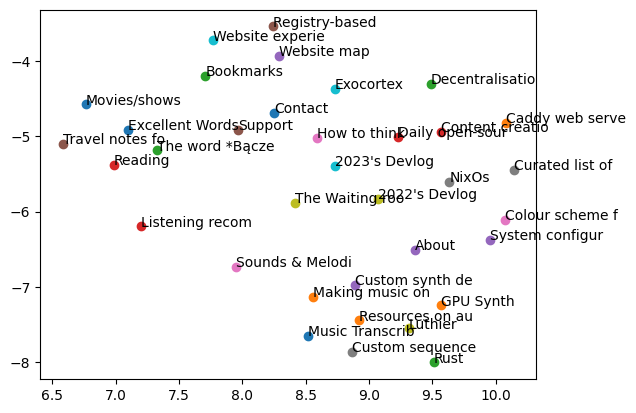

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for post, umap_result in zip(all_posts, umap_results):
    post.x, post.y = umap_result

    plt.scatter(post.x, post.y)
    ax.annotate(post.title[:15], (post.x, post.y))

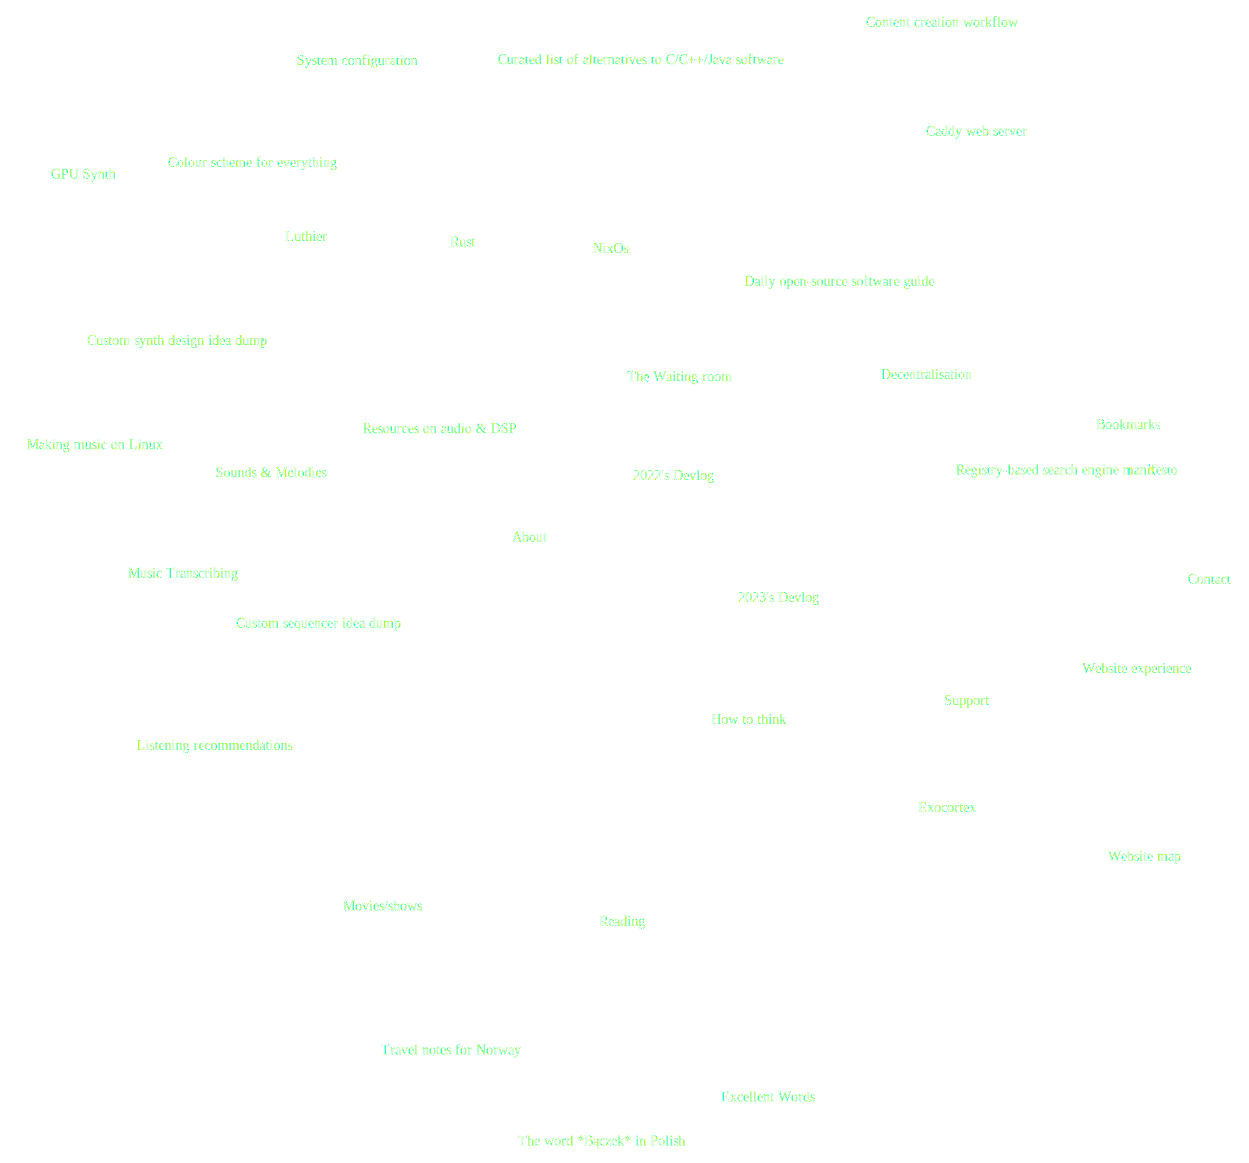

In [6]:
graph = graphviz.Graph(
    comment="All Relations",
    graph_attr={"bgcolor": "transparent", "overlap": "false"},
    format="svg",
    node_attr={"shape": "box"},
    engine="neato",
)


def make_edge_id(post_1, post_2) -> tuple[Post, Post]:
    return sorted([post_1, post_2], key=lambda p: p.title)


existing_connections: list[tuple[Post, Post]] = []


weirdness_level = sentence_transformer.encode(["weird, nerdy stuff"])[0]

for post in all_posts:
    # transparency = util.cos_sim(weirdness_level, post.embeddings)[0][0][0]
    # print(transparency)
    # transparency = f"{int(255 * post.posts_linking_to_this):02x}"
    # color = "#ffffff"
    # color += transparency

    graph.node(
        post.title,
        color=color,
        fontcolor="white",
        xlabel="🆕" if post.recently_modified else "",
        URL="/" + post.path.with_suffix("").name,
        # pos=f'{post.x/2.0},{post.y/2.0}!'
    )

    related_posts = [
        similiar_post
        for similiar_post in sorted(
            all_posts, key=lambda post_to_sort: post_to_sort.distance_embedding(post)
        )
        if similiar_post != post
    ][:2]

    connections_created = 0
    for related in related_posts:
        edge_id = make_edge_id(post, related)

        if edge_id not in existing_connections:
            graph.edge(post.title, related.title, color="white")
            existing_connections.append(edge_id)
            connections_created += 1

        # if connections_created >= 2:
        #     break

graph